# This notebook is not part of the project

#### Here is my first attemtpt for the model, where I decided, to take another approach to get a meaningful modeling result.
#### This notebook is not finished and very messy, I keep it to try and make the model work on a later point.

# Importing Libraries

In [30]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date

In [31]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [32]:
# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

In [33]:
# For resampling
from imblearn.over_sampling import SMOTE

# Loading Files

In [34]:
main_df = pd.read_csv('Prepared Frames/rated_v3.csv')

In [35]:
main_df.shape

(8661, 48)

## We drop the column that is a transformation of our target

In [36]:
print(main_df.columns)

Index(['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'tokens',
       'current_search', 'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',

In [37]:
df = main_df.drop(['Investment_Grade','Rating_numbered'],axis = 1)

## We drop columns that are just noise and not relevant to our model

In [38]:
drop_columns = ['Ticker', 'SimFinId', 'Company Name','tokens',
       'current_search', 'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)','Sector', 'IndustryId','reduced_matches']

In [39]:
df = df.drop(drop_columns, axis = 1)

# First Model

# Seperating train and test by companies

I saw extremely accurate results, this was because we treated different timepoints for different companies as completely independent.
Actually we will have to treat each company as a whole, to not leak information and be able to predict for unseen companies.
For this reason, instead of using the sklearn train test split, I will randomly select companies and split the dataframe by them.

In [40]:
# Companies:
companyframe = pd.DataFrame(list(main_df['Ticker'].unique()))

In [41]:
splitting_df = main_df.drop(['Investment_Grade','Rating_numbered'],axis = 1)

In [42]:
test_companies = companyframe.sample(frac=0.3)
test_companies_list = list(test_companies[0].unique())

In [43]:
trainframe = splitting_df[~splitting_df['Ticker'].isin(test_companies_list)]
testframe = splitting_df[splitting_df['Ticker'].isin(test_companies_list)]

In [44]:
trainframe = trainframe.drop(drop_columns, axis = 1)
testframe = testframe.drop(drop_columns, axis = 1)

In [45]:
X_train = trainframe.drop('Rating',axis = 1)
X_test = testframe.drop('Rating',axis = 1)
y_train = trainframe['Rating']
y_test = testframe['Rating']

In [46]:
X_train.columns

Index(['Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Industry', 'interest_ratio', 'income_to_interest'],
      dtype='object'

# Introducing calculated columns
From a financial standpoint, the different columns do not really mean a lot by themself.
I will bring some of them into relation with each other by calculating some basic financial metrics and see if this helps
our model.

In [47]:
# These are simplified calculations, the goal is not to have super accurate financial metrics, but to have some
# meaningful relation between the values, since for example having 1 million dollar is nice, but not if you have 200 million in debt.
def calc_fields(df):
    df['leverage'] = df['Total Liabilities']/df['Total Assets']
#     df['taxrate'] = (df['Pretax Income (Loss)'] - df['Net Income'])/df['Pretax Income (Loss)'] Tax rate made it worse
#     df['cost_of_revenue_to_revenue'] = df['Cost of Revenue']/df['Revenue']
    # I add 1 to the ínterest expense, since some values are 0
    df['cost_of_capital_to_operating_income'] = df['Interest Expense, Net']/(df['Income (Loss) from Continuing Operations']+1)
#     df['shortterm_assets_to_liabilities'] = df['Total Current Liabilities']/df['Total Liabilities']
    return df

In [48]:
def revert_fields(df):
    df = df.drop(['leverage','taxrate','cost_of_revenue_to_revenue','cost_of_capital_to_operating_income','short_liabilities_to_liabilities'])

In [49]:
X_train = calc_fields(X_train)
X_test = calc_fields(X_test)

There was a noticeable improvement in scores even with just one added field, I will consecutively try our more.

## X-y split

In [50]:
# X = df.drop('Rating',axis = 1)
# y = df['Rating']

## Train-Test Split

In [51]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Num-Cat-Split

In [52]:
# We have almost exclusively numerical columns, only the Industry column is categorical

# for column in X.columns:
#     print(column)
#     print(X[column].dtype)

In [53]:
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

## Onehot encoding

In [54]:
# Fit encoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_cat)

# Getting the column names for the later selection
column_name = encoder.get_feature_names_out(X_train_cat.columns)

# Encode train and test
train_encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns = column_name, index=X_train_cat.index)
test_encoded = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns = column_name, index=X_test_cat.index)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Scaling

In [55]:
# Fitting scaler, after trying Standard- and MinMaxScaler I saw the MinMaxScaler delivers better results.
transformer = MinMaxScaler().fit(X_train_num)

# Scaling train and test data
train_num_scaled = pd.DataFrame(transformer.transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)
test_num_scaled = pd.DataFrame(transformer.transform(X_test_num), columns = X_test_num.columns, index = X_test_num.index)

In [56]:
# Concatenating
X_train = pd.concat([train_encoded, train_num_scaled], axis = 1)
X_test = pd.concat([test_encoded,test_num_scaled], axis = 1)

In [57]:
# Saving so we can revert back later
X_train_unedited = X_train
X_test_unedited = X_test
y_train_unedited = y_train
y_test_unedited = y_test

In [58]:
X_test.shape

(2633, 97)

## Testing models

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier

In [60]:
# A function that I made in the Random Forest Lab to try out some models
def model_test(X_train,X_test,y_train,y_test):
    # Creating a list of different models
    modellist = [LogisticRegression(solver='sag'),
                 DecisionTreeClassifier(max_depth=7),
                 neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance'),
                 RandomForestClassifier(max_depth=7,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             n_jobs = -1),
                 ExtraTreesClassifier(n_estimators=100),
                 LinearSVC(),
                 BaggingClassifier()
                ]
    modelnames = ['Logistic Regression','DecisionTree','KNN','RandomForest','ExtraTrees','LinearSVC','BaggingClassifier']
    #Evaluating each model
    for i in range(len(modellist)):
        model = modellist[i]
        # Fitting
        model.fit(X_train, y_train)
        # Predicting
        predictions = model.predict(X_test)
        # Calculating confusion matrix
        cm = confusion_matrix(y_test, predictions)
        print(cm)
        # Printing different evaluation metrics
        print(modelnames[i] + " score: ", model.score(X_test, y_test))
        print(modelnames[i] + " precision: ",precision_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " recall: ",recall_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " f1: ",f1_score(y_test,predictions, average = 'weighted'))

In [61]:
model_test(X_train,X_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 20   0   0   0  20  55   0   0   0]
 [ 20   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 302 516  21   0   8   0]
 [  0   0   0 272 980  45   0   3   0]
 [  0   0  14  21 119  54   0   1   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  41  31  20   0   3   0]
 [  0   0   0  34  13   0   0   0   0]]
Logistic Regression score:  0.5161412837067983
Logistic Regression precision:  0.4777751318963319
Logistic Regression recall:  0.5161412837067983
Logistic Regression f1:  0.4856249310091477
[[ 42   3   0  11  18  21   0   0   0]
 [ 15   0   5   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  5   0   0 533 275  23   0  11   0]
 [ 13   0   0 149 944 194   0   0   0]
 [  8   0   0  18 122  61   0   0   0]
 [  0   0   0   5   0   0   0   0   0]
 [  1   0   0  60  26   0   0   8   0]
 [  0   0   0  27  10   0   0   1   9]]
DecisionTree score:  0.606532472464869
DecisionTree precision:  0.6133766243558016
DecisionTree recall:  0

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 31   0   0   0  16  48   0   0   0]
 [ 20   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 434 316  40   0  55   2]
 [ 47   0   0 460 691  77   0  25   0]
 [ 13   0   3  40 107  44   0   2   0]
 [  0   0   0   2   0   3   0   0   0]
 [  0   0   0  45  12  19   1  18   0]
 [  0   0   0  31   6   1   1   3   5]]
KNN score:  0.4644891758450437
KNN precision:  0.47841477049551506
KNN recall:  0.4644891758450437
KNN f1:  0.4649777880814551


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  27    0    0   34   34    0    0    0]
 [  29    0    0    0    6    0    0    0]
 [   0    0  490  356    1    0    0    0]
 [   0    0   72 1183   45    0    0    0]
 [  14    0   14  173    8    0    0    0]
 [   0    0    4    1    0    0    0    0]
 [   0    0   69   25    1    0    0    0]
 [   0    0   37   10    0    0    0    0]]
RandomForest score:  0.6486897075579188
RandomForest precision:  0.5781473364331954
RandomForest recall:  0.6486897075579188
RandomForest f1:  0.6006610009793848


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 25   0   0   0  18  52   0   0   0]
 [ 20   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 472 350  22   0   3   0]
 [  1   0   0 211 993  92   0   3   0]
 [  8   0   2  16 151  32   0   0   0]
 [  0   0   0   2   1   2   0   0   0]
 [  0   0   0  56   9  22   0   8   0]
 [  0   0   0  24   6   0   0   0  17]]
ExtraTrees score:  0.5875427269274591
ExtraTrees precision:  0.5811636049849963
ExtraTrees recall:  0.5875427269274591
ExtraTrees f1:  0.5715385772013466


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 20   0   0   0  20  55   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 386 434  27   0   0   0]
 [  1   0   0 306 934  59   0   0   0]
 [  0   0  19   4 118  55   0  13   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  47  27  21   0   0   0]
 [  0   0   0  38   9   0   0   0   0]]
LinearSVC score:  0.5298139004937333
LinearSVC precision:  0.5087227304557495
LinearSVC recall:  0.5298139004937333
LinearSVC f1:  0.507981775109461


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 26   2   0  30  37   0   0   0]
 [ 18   0   0   0  17   0   0   0]
 [  1   0 568 265   2   0  11   0]
 [  3   0 209 971 115   0   0   2]
 [  6   0  29 124  50   0   0   0]
 [  0   0   2   2   0   0   1   0]
 [  1   0  56  26   2   0  10   0]
 [  0   0  31   6   0   0   1   9]]
BaggingClassifier score:  0.6205848841625522
BaggingClassifier precision:  0.6059677288712075
BaggingClassifier recall:  0.6205848841625522
BaggingClassifier f1:  0.6043101838746533


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion:
We see similar scores across the models, the issue is, that we are missing some values within the datasets.

## Resampling
I will try to resample the data using SMOTE and see if we can improve the results.

In [62]:
# # Resampling does not work, since we do not have an example of every class in our dataframe to begin with.
# sm = SMOTE(random_state=100, k_neighbors=1)
# X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,y_train)

#### We retry to run our models

In [63]:
# model_test(X_train_SMOTE,X_test,y_train_SMOTE,y_test)

Resampling was not possible after selecting train and test by companies, since we do not have an entry for every class anymore.

## Feature selection

#### Taking out columns I introduced myself

In [64]:
# First i try if I can eliminate the columns I created myself earlier. Since the information is already in other columns.
Xperiment_train = X_train.drop(['interest_ratio','income_to_interest'],axis = 1)
Xperiment_test = X_test.drop(['interest_ratio','income_to_interest'],axis = 1)

In [65]:
model_test(Xperiment_train,Xperiment_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 20   0   0   0  20  55   0   0   0]
 [ 20   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 302 516  21   0   8   0]
 [  0   0   0 272 980  45   0   3   0]
 [  0   0  14  21 119  54   0   1   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  41  31  20   0   3   0]
 [  0   0   0  34  13   0   0   0   0]]
Logistic Regression score:  0.5161412837067983
Logistic Regression precision:  0.4777751318963319
Logistic Regression recall:  0.5161412837067983
Logistic Regression f1:  0.4856249310091477
[[  56    3    0    3    0   33    0    0    0]
 [  19    0    1    0    0   15    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   2    0    0  490  344    5    0    6    0]
 [  10    0    0  114 1027  148    0    1    0]
 [  12    0    0   20  148   29    0    0    0]
 [   0    0    0    5    0    0    0    0    0]
 [   0    1    0   60    7   19    0    8    0]
 [   0    0    0   27   10    0    0    1    9]]
DecisionTree score:  0.61

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 31   0   0   0  16  48   0   0   0]
 [ 20   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 434 317  39   0  55   2]
 [ 47   0   0 461 691  77   0  24   0]
 [ 13   0   3  40 107  44   0   2   0]
 [  0   0   0   2   0   3   0   0   0]
 [  0   0   0  45  12  19   1  18   0]
 [  0   0   0  31   6   1   1   3   5]]
KNN score:  0.4644891758450437
KNN precision:  0.478139233733271
KNN recall:  0.4644891758450437
KNN f1:  0.46485018639592995


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  26    0    0   50   19    0    0    0]
 [  30    0    0    0    5    0    0    0]
 [   0    0  499  341    7    0    0    0]
 [   0    0  100 1141   59    0    0    0]
 [   9    0   15  174   11    0    0    0]
 [   0    0    4    1    0    0    0    0]
 [   0    0   69   25    1    0    0    0]
 [   0    0   38    9    0    0    0    0]]
RandomForest score:  0.6369160653247247
RandomForest precision:  0.5679796774088293
RandomForest recall:  0.6369160653247247
RandomForest f1:  0.5920700314154489


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 20   0   0   0  29  46   0   0   0]
 [  5   0   0   0   0  30   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 456 351  36   0   4   0]
 [  0   0   0 222 984  88   0   6   0]
 [  7   0   2  18 159  23   0   0   0]
 [  0   0   0   2   1   2   0   0   0]
 [  0   0   0  56   7  24   0   8   0]
 [  0   0   0  23   6   1   0   0  17]]
ExtraTrees score:  0.5727307254082795
ExtraTrees precision:  0.5686201900598448
ExtraTrees recall:  0.5727307254082795
ExtraTrees f1:  0.5570602799308304


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 20   0   0   0  20  55   0   0   0]
 [  1   0   0   0   0  34   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 386 434  27   0   0   0]
 [  1   0   0 306 934  59   0   0   0]
 [  0   0  19   4 118  55   0  13   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  47  27  21   0   0   0]
 [  0   0   0  38   9   0   0   0   0]]
LinearSVC score:  0.5298139004937333
LinearSVC precision:  0.5072298247479523
LinearSVC recall:  0.5298139004937333
LinearSVC f1:  0.5079166116086483


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 50   0   0   6  39   0   0   0]
 [  6   0   0   3  26   0   0   0]
 [  5   0 557 276   3   0   6   0]
 [  8   0 240 905 147   0   0   0]
 [ 12   0  38 118  41   0   0   0]
 [  0   0   2   3   0   0   0   0]
 [  0   0  55  12  20   0   8   0]
 [  0   0  22   8   0   0   2  15]]
BaggingClassifier score:  0.5985567793391569
BaggingClassifier precision:  0.6017016803128372
BaggingClassifier recall:  0.5985567793391569
BaggingClassifier f1:  0.5909205476890202


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results got slightly worse, we kep the columns.

## Feature selection with KBest

In [66]:
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.feature_selection import chi2

In [67]:
# First we do a quick transformation and see if we achieve anything this way
model = SelectKBest(chi2, k=35).fit(X_train, y_train)
XTr_temp = pd.DataFrame(model.transform(X_train), index = X_train.index)
Xte_temp = pd.DataFrame(model.transform(X_test), index = X_test.index)

In [68]:
model_test(XTr_temp,Xte_temp,y_train,y_test)

[[  20    0    0   20   55    0    0    0]
 [   0    0    0    0   35    0    0    0]
 [   0    0  187  614   46    0    0    0]
 [   0    0  117 1117   66    0    0    0]
 [   0    0   40  117   52    0    0    0]
 [   0    0    2    3    0    0    0    0]
 [   0    0   28   47   20    0    0    0]
 [   0    0   46    1    0    0    0    0]]
Logistic Regression score:  0.5225977971895177
Logistic Regression precision:  0.4817611455293171
Logistic Regression recall:  0.5225977971895177
Logistic Regression f1:  0.4672515389409609
[[  13    5    1   23   53    0    0    0]
 [   0   15    0    0   20    0    0    0]
 [   0    0  343  466   35    1    2    0]
 [  10    0   64 1081  128    0   17    0]
 [   7    0   12  140   50    0    0    0]
 [   0    0    0    5    0    0    0    0]
 [   0    0   22   54   19    0    0    0]
 [   0    0    8   22    0    0    0   17]]
DecisionTree score:  0.5769084694265096
DecisionTree precision:  0.5996682998254562
DecisionTree recall:  0.576908469426

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 22   0   0   0  23  50   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  3   0   0 392 344  80   0  28   0]
 [  8   0   0 370 751 167   0   4   0]
 [ 12   0   7  36 105  49   0   0   0]
 [  0   0   0   2   0   3   0   0   0]
 [  0   0   0  25  48  22   0   0   0]
 [  0   0   0  14   8   1   0   1  23]]
KNN score:  0.4698063045955184
KNN precision:  0.48525450695490574
KNN recall:  0.4698063045955184
KNN f1:  0.4728325263132293


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[   0    0    1   54   40    0    0    0]
 [   0    0    0   15   20    0    0    0]
 [   0    0  383  464    0    0    0    0]
 [   0    0   70 1220   10    0    0    0]
 [   0    0   13  189    7    0    0    0]
 [   0    0    0    5    0    0    0    0]
 [   0    0   44   51    0    0    0    0]
 [   0    0   31   16    0    0    0    0]]
RandomForest score:  0.6114698063045955
RandomForest precision:  0.533616945366525
RandomForest recall:  0.6114698063045955
RandomForest f1:  0.5448090846185906


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 25   0   0   0  31  39   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 376 392  72   0   7   0]
 [  5   1   0 253 903 136   0   2   0]
 [ 11   0   7  17 161  13   0   0   0]
 [  0   0   0   2   0   3   0   0   0]
 [  0   0   0  19  51  23   0   2   0]
 [  0   0   0  24   5   1   0   0  17]]
ExtraTrees score:  0.5074060007595899
ExtraTrees precision:  0.513601893356754
ExtraTrees recall:  0.5074060007595899
ExtraTrees f1:  0.498924909745107


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  20    0    0    0   20   55    0    0    0]
 [   0    0    0    0    0   35    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0  231  570   46    0    0    0]
 [   0    0    0  147 1061   92    0    0    0]
 [   0    0    9   16  117   52    0   15    0]
 [   0    0    0    2    3    0    0    0    0]
 [   0    0    0   46   29   20    0    0    0]
 [   0    0    0   46    1    0    0    0    0]]
LinearSVC score:  0.5180402582605393
LinearSVC precision:  0.4929796605970017
LinearSVC recall:  0.5180402582605393
LinearSVC f1:  0.4779528767285274


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 14   5  10  18  48   0   0   0]
 [  0  15   0   0  20   0   0   0]
 [  0   0 470 318  57   0   1   1]
 [ 17   0 312 834 118   0  19   0]
 [ 18   0  38 130  23   0   0   0]
 [  0   0   2   0   3   0   0   0]
 [  0   0  29  43  23   0   0   0]
 [  0   0  13  16   1   0   0  17]]
BaggingClassifier score:  0.5214584124572731
BaggingClassifier precision:  0.5193547030219433
BaggingClassifier recall:  0.5214584124572731
BaggingClassifier f1:  0.516300823377817


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I tried out different values for K, it deteriorates our scores further, we see what happens when trying to eliminate multicollinearity.

## Eliminating multicollinearity

In [69]:
# We concatenate X_train and y_train to see where we have correltaions with the target
df_corrcheck = pd.concat([X_train, y_train], axis=1)

In [70]:
# Creating a correlation matrix
correlations_matrix = df_corrcheck.corr()

In [71]:
# Since the matrix is a bit big to inspect visually, we will leave out all the columns,
# where we don't have a correlation above 0.7 apart from the one the label has with itself
for column in correlations_matrix:
    # nlargest gives back the two highest values, we select the second one since the first is always 1
    if correlations_matrix[column].nlargest(2)[1] < 0.7:
        correlations_matrix = correlations_matrix.drop(column, axis = 1)

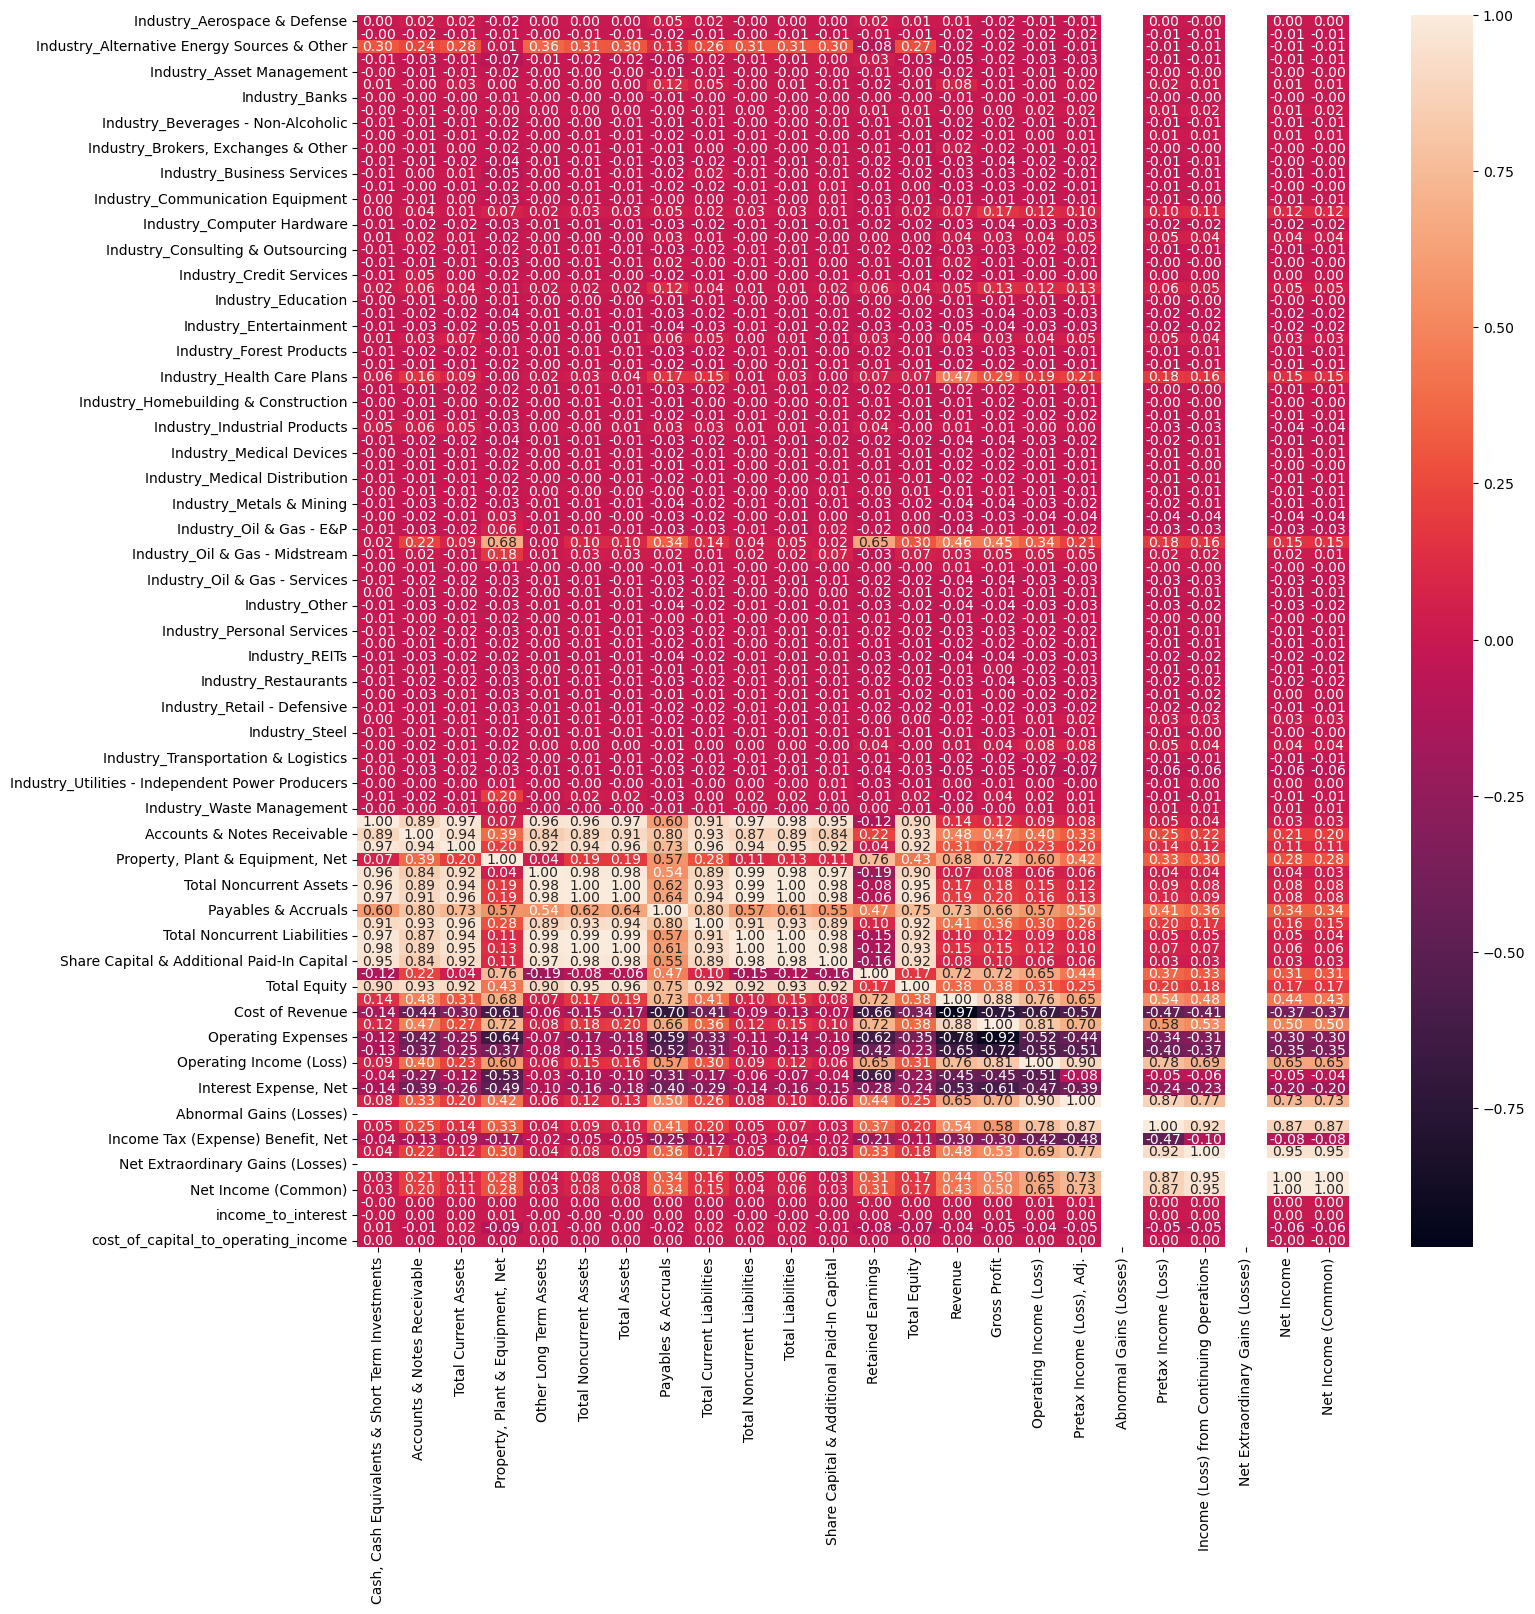

In [72]:
# We create a heatmap of the reduced correlation matrix
plt.figure(figsize = (16,16))
sns.heatmap(correlations_matrix, annot=True, fmt='.2f')
plt.show()

In [73]:
correlations_matrix.columns

Index(['Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Gross Profit',
       'Operating Income (Loss)', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income',
       'Net Income (Common)'],
      dtype='object')

In [74]:
# I will drop some columns, with severe multicollinearity and see if we imrpove our model.
columns_to_drop = ['Accounts & Notes Receivable', 'Total Current Assets',
       'Other Long Term Assets', 'Total Noncurrent Assets', 'Total Assets',
       'Payables & Accruals', 'Total Current Liabilities',
       'Total Noncurrent Liabilities', 'Total Liabilities',
       'Share Capital & Additional Paid-In Capital']
X_train = X_train.drop(columns_to_drop,axis = 1)
X_test = X_test.drop(columns_to_drop,axis = 1)

In [75]:
# Again we see a sharp downmturn.
model_test(XTr_temp,Xte_temp,y_train,y_test)

[[  20    0    0   20   55    0    0    0]
 [   0    0    0    0   35    0    0    0]
 [   0    0  187  614   46    0    0    0]
 [   0    0  117 1117   66    0    0    0]
 [   0    0   40  117   52    0    0    0]
 [   0    0    2    3    0    0    0    0]
 [   0    0   28   47   20    0    0    0]
 [   0    0   46    1    0    0    0    0]]
Logistic Regression score:  0.5225977971895177
Logistic Regression precision:  0.4817611455293171
Logistic Regression recall:  0.5225977971895177
Logistic Regression f1:  0.4672515389409609
[[  13    5    1   23   53    0    0    0]
 [   0   15    0    0   20    0    0    0]
 [   0    0  343  465   35    0    4    0]
 [  10    0   64 1081  128    0   17    0]
 [   7    0   12  140   50    0    0    0]
 [   0    0    0    5    0    0    0    0]
 [   0    0   17   56   19    0    3    0]
 [   0    0    8   22    0    0    0   17]]
DecisionTree score:  0.5780478541587543
DecisionTree precision:  0.6067670834825785
DecisionTree recall:  0.578047854158

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 22   0   0   0  23  50   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  3   0   0 392 344  80   0  28   0]
 [  8   0   0 370 751 167   0   4   0]
 [ 12   0   7  36 105  49   0   0   0]
 [  0   0   0   2   0   3   0   0   0]
 [  0   0   0  25  48  22   0   0   0]
 [  0   0   0  14   8   1   0   1  23]]
KNN score:  0.4698063045955184
KNN precision:  0.48525450695490574
KNN recall:  0.4698063045955184
KNN f1:  0.4728325263132293


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[   0    0    2   61   32    0    0    0]
 [   0    0    0   15   20    0    0    0]
 [   0    0  375  472    0    0    0    0]
 [   0    0   67 1223   10    0    0    0]
 [   0    0   15  187    7    0    0    0]
 [   0    0    0    5    0    0    0    0]
 [   0    0   44   51    0    0    0    0]
 [   0    0   31   16    0    0    0    0]]
RandomForest score:  0.6095708317508546
RandomForest precision:  0.5314121685456101
RandomForest recall:  0.6095708317508546
RandomForest f1:  0.5413645399245703


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 25   0   0   0  28  42   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 366 384  92   0   5   0]
 [  2   0   0 277 892 127   0   2   0]
 [ 11   0   7  17 149  25   0   0   0]
 [  0   0   0   2   0   3   0   0   0]
 [  0   0   0  20  50  23   0   2   0]
 [  0   0   0  24   5   1   0   0  17]]
ExtraTrees score:  0.5039878465628561
ExtraTrees precision:  0.5141235523923418
ExtraTrees recall:  0.5039878465628561
ExtraTrees f1:  0.49686817557009505


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  20    0    0    0   20   55    0    0    0]
 [   0    0    0    0    0   35    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0  231  570   46    0    0    0]
 [   0    0    0  147 1061   92    0    0    0]
 [   0    0    9   16  117   52    0   15    0]
 [   0    0    0    2    3    0    0    0    0]
 [   0    0    0   46   29   20    0    0    0]
 [   0    0    0   46    1    0    0    0    0]]
LinearSVC score:  0.5180402582605393
LinearSVC precision:  0.4929796605970017
LinearSVC recall:  0.5180402582605393
LinearSVC f1:  0.4779528767285274


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 28   5   0  10  52   0   0   0]
 [  0  15   0   0  20   0   0   0]
 [  1   0 448 352  37   0   9   0]
 [ 14   0 309 845 117   0  15   0]
 [ 18   0  28 114  49   0   0   0]
 [  0   0   2   0   3   0   0   0]
 [  0   0  40  32  23   0   0   0]
 [  0   0  13  16   1   0   0  17]]
BaggingClassifier score:  0.5324724648689707
BaggingClassifier precision:  0.5335780498912297
BaggingClassifier recall:  0.5324724648689707
BaggingClassifier f1:  0.5283927367029884


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion:
After revisiting the part of the project where we matched the companies with the missing data, we were able to improve the results substantially. But we still did not get enough data to support modelling with this many classes.
Deleting more columns to 

For the classes our model has already seen, it works reasonably well, but we are definately lacking the data to build upon that.

# Alternative approach
Since we do not have enough data, we will revert to a simpler model. Even if we cannot predict the exact rating, we should be able to predict if a company is investment grade or not.

In [76]:
# Getting back our scaled but otherwise unaltered data
X_train = X_train_unedited
X_test = X_test_unedited
y_train = y_train_unedited
y_test = y_test_unedited

#### Convert targets

In [77]:
# We convert our targets
# We define investment grade
inv_grade = ['Aaa','Aa','A','Baa']

In [78]:
def convert(rating):
    if rating in inv_grade:
        return 'Investment Grade'
    else:
        return 'Non Investment Grade'

In [79]:
y_train = y_train.apply(convert)

In [80]:
y_test = y_test.apply(convert)

In [81]:
# We test this classification
model_test(X_train,X_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[ 172  167]
 [  68 2226]]
Logistic Regression score:  0.9107481959741739
Logistic Regression precision:  0.90271891415159
Logistic Regression recall:  0.9107481959741739
Logistic Regression f1:  0.9040604599913059
[[ 125  214]
 [ 188 2106]]
DecisionTree score:  0.8473224458792252
DecisionTree precision:  0.8423021885467294
DecisionTree recall:  0.8473224458792252
DecisionTree f1:  0.8447084323466102
[[ 174  165]
 [ 185 2109]]
KNN score:  0.8670717812381314
KNN precision:  0.8704349484808752
KNN recall:  0.8670717812381314
KNN f1:  0.8686851982521181
[[ 143  196]
 [  66 2228]]
RandomForest score:  0.9004937333839726
RandomForest precision:  0.8888943864702498
RandomForest recall:  0.9004937333839726
RandomForest f1:  0.8900618830212237
[[ 201  138]
 [ 122 2172]]
ExtraTrees score:  0.901253323205469
ExtraTrees precision:  0.89932111678792
ExtraTrees recall:  0.901253323205469
ExtraTrees f1:  0.9002315940380722
[[ 194  145]
 [ 111 2183]]
LinearSVC score:  0.9027725028484618
LinearSVC pre

We get fairly good scores, this seems to be something we can build upon

## Resampling
We try again to better our results by resampling

In [82]:
# Resampling does not work, since we do not have an example of every class in our dataframe to begin with.
sm = SMOTE(random_state=100, k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,y_train)

In [83]:
model_test(X_train_SMOTE,X_test,y_train_SMOTE,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[ 235  104]
 [ 542 1752]]
Logistic Regression score:  0.7546524876566654
Logistic Regression precision:  0.8613694850287436
Logistic Regression recall:  0.7546524876566654
Logistic Regression f1:  0.7898513850065983
[[ 215  124]
 [ 363 1931]]
DecisionTree score:  0.8150398784656285
DecisionTree precision:  0.8665693903246264
DecisionTree recall:  0.8150398784656285
DecisionTree f1:  0.8340609309203506
[[ 177  162]
 [ 226 2068]]
KNN score:  0.8526395746297
KNN precision:  0.8645049341072163
KNN recall:  0.8526395746297
KNN f1:  0.8579524039961743
[[ 212  127]
 [ 326 1968]]
RandomForest score:  0.8279529054310673
RandomForest precision:  0.869168309394532
RandomForest recall:  0.8279529054310674
RandomForest f1:  0.8435721403418507
[[ 207  132]
 [ 125 2169]]
ExtraTrees score:  0.9023927079377136
ExtraTrees precision:  0.9015442546025382
ExtraTrees recall:  0.9023927079377136
ExtraTrees f1:  0.9019579262226102
[[ 235  104]
 [ 467 1827]]
LinearSVC score:  0.7831371059627801
LinearSVC prec

Some scores got better some got worse, we don't see a big impact with resampling, so we go on without.

## Hyperparameter search
Since eliminating multicollinearity did not change our result in a meaningful way before, we will now try to better the results with hyperparameter tuning for our best performing models.

In [84]:
# Random search
from sklearn.model_selection import RandomizedSearchCV

In [85]:
#  ExtraTrees classifier stands out with the best score, we will try to build on that
model = ExtraTreesClassifier()

In [86]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [87]:
parameters =  { 'n_estimators' : [100,300,500],
               'criterion': ['gini','entropy'],
               'max_features':['auto',None],
                'warm_start':[True,False],
                'class_weight':[None,'balanced'],
                'n_jobs' : [-1]
#                'splitter' : ["best", "random"],
#                'max_depth' : ['None',3,6,10],
                }
              

In [88]:
random_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter=25, cv = 5, n_jobs = 10, scoring = "precision")

In [89]:
# random_search.fit(X_train,y_train)

# random_search.best_params_

In [90]:
# We try the model with the parameters
model = ExtraTreesClassifier( warm_start = False,
 n_jobs = -1,
 n_estimators = 500,
 max_features = None,
 criterion = 'entropy',
 class_weight = None)

In [91]:
model.fit(X_train, y_train)
# Predicting
predictions = model.predict(X_test)
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_test, y_test))
print(" precision: ",precision_score(y_test,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_test,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_test,predictions, average = 'weighted'))

[[ 203  136]
 [ 159 2135]]
 score:  0.8879605013292822
 precision:  0.8912741523532033
 recall:  0.8879605013292822
 f1:  0.8895162782159804


In [92]:
# We tried to score for precision we try with the parameters delivered for that
model = ExtraTreesClassifier( warm_start = True,
 n_jobs = -1,
 n_estimators = 100,
 max_features = None,
 criterion = 'gini',
 class_weight= 'balanced')

In [93]:
model.fit(X_train, y_train)
# Predicting
predictions = model.predict(X_test)
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_test, y_test))
print(" precision: ",precision_score(y_test,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_test,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_test,predictions, average = 'weighted'))

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:765: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


[[ 187  152]
 [ 161 2133]]
 score:  0.8811241929358147
 precision:  0.8824782020561082
 recall:  0.8811241929358147
 f1:  0.8817860305461324
